In [11]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pathlib 
import datetime
import wtfutil
import matplotlib.pyplot as plt
import multiprocessing as mp

In [18]:
STARTDATE = '2018-04-30'
ENDDATE = '2018-05-17'

datasetname_in = 'data'
datasetname_out = 'dataset-aggregate'

currdate = '2017-12-27'

date_ref = pd.to_datetime(currdate)



def mp_process(bucket):
    txpool = pd.concat([pd.read_parquet(p) for p in bucket]).query('diff == 1')
    feeagg = wtfutil.feeagg(txpool, 800)
    return feeagg.mvs / len(bucket) * 40
#%%time

def process_date(date_ref):
    date_ref = pd.to_datetime(date_ref)
    dirin_path = pathlib.Path(f'{datasetname_in}/{date_ref.strftime("%Y/%m/%d")}')
    fileout_path = pathlib.Path(datasetname_out) / date_ref.strftime("%Y/%m/%d") / 'add.parq'

    buckets = [list() for x in range(144)]
    buckets_processed = []

    midnight_ts = date_ref.timestamp()

    for p in dirin_path.glob('*_diff.parq'):
        i = int(midnight_ts-int(p.name.split('_')[1]))//600
        buckets[i].append(p)

    with mp.Pool(18) as p:
        buckets_processed = p.map(mp_process, buckets)

    df = pd.DataFrame(
        data=buckets_processed, 
        index=pd.DatetimeIndex(start=date_ref, periods=144, freq='10T'),
        dtype=np.float32
    )

    # cleanup for storing in pq
    dfpq = df.T.sort_index()
    dfpq.index.name = None
    dfpq.columns = dfpq.columns.astype(str)
    fileout_path.parent.mkdir(parents=True, exist_ok=True)
    dfpq.to_parquet(fileout_path, compression='brotli')


In [19]:
for date_ref in pd.date_range(STARTDATE, ENDDATE):
    print(date_ref)
    process_date(date_ref)

2018-04-30 00:00:00
2018-05-01 00:00:00
2018-05-02 00:00:00
2018-05-03 00:00:00
2018-05-04 00:00:00
2018-05-05 00:00:00
2018-05-06 00:00:00
2018-05-07 00:00:00
2018-05-08 00:00:00
2018-05-09 00:00:00
2018-05-10 00:00:00
2018-05-11 00:00:00
2018-05-12 00:00:00
2018-05-13 00:00:00
2018-05-14 00:00:00
2018-05-15 00:00:00
2018-05-16 00:00:00
2018-05-17 00:00:00


In [20]:
def readback(date_ref):
    date_ref = pd.to_datetime(date_ref)
    filein_path = pathlib.Path(datasetname_out) / date_ref.strftime("%Y/%m/%d") / 'add.parq'
    
    return pd.read_parquet(filein_path)


In [21]:
%%time
d = wtfutil.fa_ceilgroup(readback('2018-03-09')).T.aggregate(np.average)



CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 30.8 ms


In [22]:
import wtfviz

In [25]:
wtfviz.CBar(wtfutil.fa_ceilgroup(readback('2018-05-17')).T.aggregate(np.average), wmod=3, h=500)

In [26]:
pathlib.Path()

PosixPath('.')

In [27]:

# entries, compression ratio, filesize_MB
[last.stat().st_size/1e6, p_out.stat().st_size/1e6, len(df_out), p_out.stat().st_size/last.stat().st_size, p_out.stat().st_size/1e6]

NameError: name 'last' is not defined

In [28]:
filepath = pathlib.Path(datasetname_out) / '2018' / '03' / '01' / 'add.parq'

In [37]:
df_reread = pd.read_parquet(filepath)
df = df_reread
df.columns = pd.to_datetime(df.columns)
df = df[::-1]
df.head()
df.to_period('10T', axis=1).columns[0]


Period('2018-03-01 00:00', '10T')

In [38]:
def ceilgroup(df, div=40):
    nidx = np.arange(800,-div,-div)
    series = []
    for n,idx in enumerate(nidx):
        if idx == 0:
            s = df[df.index == 0].sum()
        else:
            s = df[np.logical_and(df.index <= idx, nidx[n+1] < df.index)].sum()
        series.append(s)    
    return pd.DataFrame(series, index=nidx) 


In [39]:
#%%time
df80 = wtfutil.fa_ceilgroup(df,80).T
df80

,800,720,640,560,480,400,320,240,160,80,0
2018-03-01 00:00:00,0.000000,0.002265,0.013085,0.011513,0.041666,0.169227,0.068194,0.098010,0.026415,0.004036,0.000230
2018-03-01 00:10:00,0.004862,0.000607,0.012716,0.012872,0.108966,0.118140,0.043626,0.077444,0.037705,0.009212,0.001076
2018-03-01 00:20:00,0.000000,0.003288,0.006865,0.012577,0.049903,0.294741,0.047912,0.106824,0.024932,0.064855,0.000225
2018-03-01 00:30:00,0.000000,0.000636,0.016002,0.015832,0.035406,0.106297,0.206433,0.091145,0.030811,0.007927,0.000000
2018-03-01 00:40:00,0.001193,0.002104,0.008923,0.020577,0.134872,0.129290,0.086601,0.095998,0.022431,0.011006,0.001719
2018-03-01 00:50:00,0.000000,0.001344,0.012469,0.014047,0.056492,0.196528,0.123171,0.097902,0.049897,0.007902,0.003189
2018-03-01 01:00:00,0.000000,0.002310,0.013104,0.009731,0.024261,0.133455,0.078990,0.064261,0.012343,0.015588,0.000407
2018-03-01 01:10:00,0.000673,0.000677,0.006377,0.009820,0.056496,0.167922,0.063257,0.074104,0.017549,0.017310,0.000000
2018-03-01 01:20:00,0.000000,0.001257,0.010126,0.013858,0.076774,0.189436,0.137837,0.083851,0.021053,0.042732,0.000244
2018-03-01 01:30:00,0.000000,0.000835,0.011507,0.019622,0.069247,0.177724,0.079282,0.082940,0.046026,0.009826,0.000000


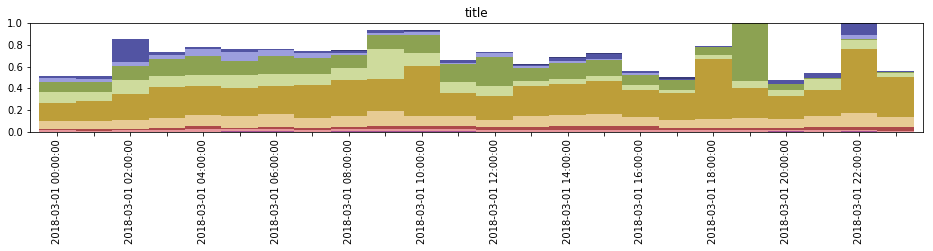

In [43]:
#df80 = df80.T
fig = plt.figure(figsize=(16,2), dpi=72)
ax = plt.subplot(111)
ax.set_ylim([0,1])
df80=df80.resample('60T').agg(np.average)
df80.plot(kind='bar', width=1, stacked=True, colormap='tab20b_r', ax=ax, legend=False, title='title')
#df80.plot(kind='area', stacked=True, colormap='tab20b_r', ax=ax, legend=False, title='title')

for n, label in enumerate(ax.get_xticklabels()):
    label.set_visible(n % 2 == 0)

plt.show()


In [41]:
df.size

115344

In [189]:
df0 = pd.DataFrame(ceilgroup(df,80).T.agg(np.average))
df0.style.bar()

TypeError: <class 'numpy.int64'> type object 800

In [455]:
%%time

div = 40

nidx = np.arange(800,-div,-div)
series = []
for n,idx in enumerate(nidx):
    if idx == 0:
        s = df[df.index == 0].sum()
    else:
        s = df[np.logical_and(df.index <= idx, nidx[n+1] < df.index)].sum()
    series.append(s)    
df0 = pd.DataFrame(series, index=nidx) 

        
#     0 in pd.Interval(left=0, right=0, closed='both')
#     df.index in pd.Interval(left=0, right=0, closed='both')
#df[pd.cut(df.index, np.arange(0,801,40))[1]]


CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.1 ms


In [435]:
div=80
bins = pd.Int64Index(np.arange(800,-div,-div))
bins

Int64Index([800, 720, 640, 560, 480, 400, 320, 240, 160, 80, 0], dtype='int64')

In [383]:
np.digitize(df.index, bins)

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8

In [394]:
pd.

array([11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8